## Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import jdatetime
import math

## Loading dataset

In [2]:
df = pd.read_csv("scrapping/dataset.csv")
df.head()

,PROVINCE,PRICE,TYPE,YEAR,MONTH,DAY,INFLATION_RATE
0,تهران,102500.0,گوسفند,1392,2,23,34.0
1,تهران,105000.0,گوساله,1392,2,23,34.0
2,اصفهان,100000.0,گوسفند,1392,2,23,34.0
3,اصفهان,100000.0,گوساله,1392,2,23,34.0
4,يزد,107500.0,گوسفند,1392,2,23,34.0


## Setting number for non continuous columns

### Provinces

In [3]:
_provinces = df.PROVINCE.unique()
PROVINCES = np.stack( [ np.arange(1 , _provinces.size + 1) , _provinces ] , 1 )
PROVINCES

array([[1, 'تهران'],
       [2, 'اصفهان'],
       [3, 'يزد'],
       [4, 'خراسان رضوی'],
       [5, 'فارس'],
       [6, 'اردبيل'],
       [7, 'کردستان'],
       [8, 'همدان'],
       [9, 'قم'],
       [10, 'سیستان و بلوچستان'],
       [11, 'آذربايجان شرقي'],
       [12, 'مرکزي'],
       [13, 'چهارمحال بختياري'],
       [14, 'آذربايجان غربي']], dtype=object)

### Types

In [4]:
_types = df.TYPE.unique()
TYPES = np.stack( [ np.arange(1 , _types.size + 1), _types ], 1 )
TYPES

array([[1, 'گوسفند'],
       [2, 'گوساله']], dtype=object)

#### Placing Keys

In [5]:
df.PROVINCE = df.PROVINCE.apply(lambda x: PROVINCES[np.where(PROVINCES == x)[0][0]][0])
df.TYPE = df.TYPE.apply(lambda x: TYPES[np.where(TYPES == x)[0][0]][0])

# An Idea : Converting YEAR,MONTH,DAY to a new parameter

In [6]:
cdf = df[["PROVINCE" , "PRICE" , "TYPE" , "INFLATION_RATE"]].assign(
    DATE=np.array([jdatetime.datetime(*row[1]).timestamp()  for row in df[ [ "YEAR" , "MONTH" , "DAY" ] ].iterrows() ])
)
cdf.head()

,PROVINCE,PRICE,TYPE,INFLATION_RATE,DATE
0,1,102500.0,1,34.0,1.368391e+09
1,1,105000.0,2,34.0,1.368391e+09
2,2,100000.0,1,34.0,1.368391e+09
3,2,100000.0,2,34.0,1.368391e+09
4,3,107500.0,1,34.0,1.368391e+09


## Data for Spetefic PROVINCE and TYPE

In [7]:
fars_cow = cdf[(cdf.PROVINCE == 5) & (cdf.TYPE == 2)]

### Making Test and Train Data

In [8]:
mask = np.random.rand(len(fars_cow)) < 0.8
train = fars_cow[mask]
test = fars_cow[~mask]

train_x_data = train.DATE * (10**-8)
train_y_data = train.PRICE * (10**-8)

test_x_data = test.DATE * (10**-8)
test_y_data = test.PRICE * (10**-8)

# Ploting Data

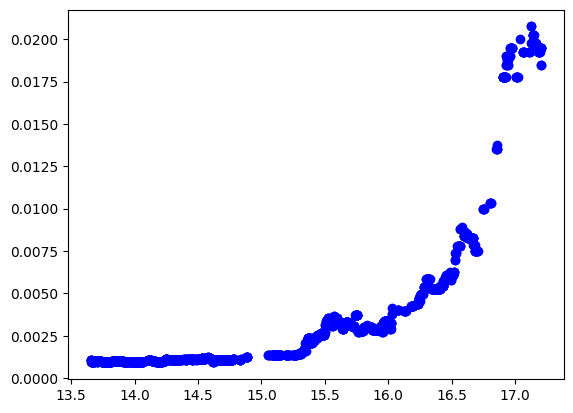

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_x_data, train_y_data, color="blue")

# Modeling

In [10]:
g = np.polyfit(np.exp(train_x_data) , train_y_data , 1)
predicted_values = g[0] * np.exp(train_x_data) + g[1]

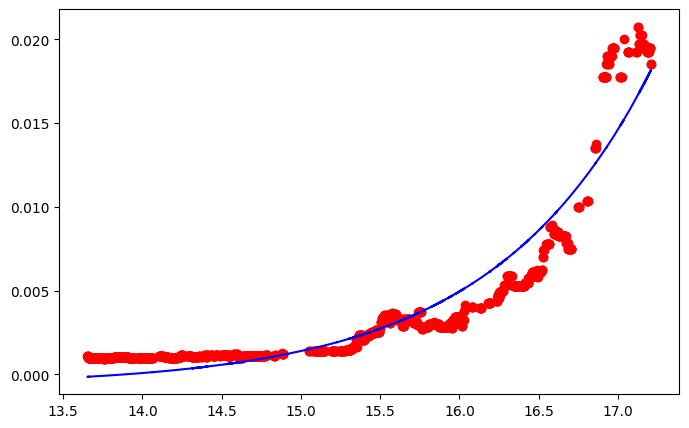

In [11]:
plt.figure(figsize=(8,5))
plt.scatter(train_x_data, train_y_data, color="red")
plt.plot(train_x_data, predicted_values , color="blue")

# Results

In [12]:
r2 = r2_score(test_y_data, g[0] * np.exp(test_x_data) + g[1])
print("The R^2 Score is: %0.2f" % r2)

The R^2 Score is: 0.91


In [13]:
mae_error = (np.abs(predicted_values - train_y_data).sum() / len(predicted_values))* (10**8)
def guess_the_price(y,m,d) -> int:
    return (g[0] * math.exp(jdatetime.datetime(y,m,d).timestamp() * (10**-8) ) + g[1]) * (10**8)

In [14]:
predict = guess_the_price(1403,4,30)
print("Price FROM (IRT): %d" % (predict * 0.1 - mae_error * 0.1))
print("Price Close To (IRT): %d" % (predict * 0.1))
print("Price To (IRT): %d" % (predict * 0.1 + mae_error * 0.1))

Price FROM (IRT): 171839
Price Close To (IRT): 182702
Price To (IRT): 193565
